# Study showing Logistic Regression use for fraud detection

Studies have been done prior that demonstrates how Logistic Regression can be used for fraud detection.

Petrlik, I., Lezama, P., Rodriguez, C., Inquilla, R., Reyna-González, J. E., & Esparza, R. (2022). Electricity Theft Detection using Machine Learning. International Journal of Advanced Computer Science and Applications, 13(12).

For effective learning, there ideally should be enough data from both classes, fraudulent and non-fraudulent. However, for energy consumption cases such as these, actual fraud cases are typically rare compared to normal cases, leading to severe class imbalance. The imbalance will cause more challenges in learning without data treatment techniques. As such, over-sampling the minority (fraudulent) class was done to address the imbalance.

___

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight, resample
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, precision_score, log_loss, recall_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import ADASYN
import joblib

In [3]:
# Loading aggregated dataset
aggregated_invoice = pd.read_csv("aggregated_datasetV3.csv")
aggregated_invoice.columns

Index(['region', 'date', 'dis', 'id', 'catg', 'target', 'id_',
       'consommation_level_1_mean', 'consommation_level_1_max',
       'consommation_level_1_std',
       ...
       'consommation_level_4_2010.0', 'consommation_level_4_2011.0',
       'consommation_level_4_2012.0', 'consommation_level_4_2013.0',
       'consommation_level_4_2014.0', 'consommation_level_4_2015.0',
       'consommation_level_4_2016.0', 'consommation_level_4_2017.0',
       'consommation_level_4_2018.0', 'consommation_level_4_2019.0'],
      dtype='object', length=195)

# Preparing data for Logistic Regression

The dataset has to be split and the imbalanced data has to be handled as the number of fraud cases are underrepresented.

# Splitting the dataset
Using `sklearn`, the data is split into 80% training and 20% testing.

In [4]:
# Separating features & target
X = aggregated_invoice.drop(columns = ["target", "date", "id"])
y = aggregated_invoice["target"]

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Check distribution of target
print(y_train.value_counts(normalize = True)) # Training set
print(y_test.value_counts(normalize = True)) # Testing set

target
0    0.956133
1    0.043867
Name: proportion, dtype: float64
target
0    0.956152
1    0.043848
Name: proportion, dtype: float64


# Standardisation of data

For better model performance, standardisation will be carried out on both train and test splits separately.

In [5]:
X_train_standardised = StandardScaler().fit_transform(X_train.select_dtypes(include = ["number"]))
X_test_standardised = StandardScaler().fit_transform(X_test.select_dtypes(include = ["number"]))

# Balancing data

Since the dataset is highly imbalanced (as seen by the proportions above), where only a small fraction of it constitutes data for fraud, ADASYN and SMOTE can be used to balance the disparity.

With fraud data constituting a mere ~5% of the entire dataset, ADASYN was chosen to increase the number of fraud datapoints, allowing the model to learn more effectively.

In [6]:
# Generating synthetic data using ADASYN for the minority class
ada = ADASYN(random_state = 42)
X_resampled_ada, y_resampled_ada = ada.fit_resample(X_train_standardised, y_train)

# Checking new class distribution
print(pd.Series(y_resampled_ada).value_counts())

target
0    8980
1    8887
Name: count, dtype: int64


# Logistic regression model without hyperparameter tuning

Now that the data has been processed, it will be run through the Logistic Regression model. Below outlines the model architecture, without hyperparameter tuning.

In [ ]:
# Defining the model
log_reg = LogisticRegression(max_iter = 1000, random_state = 42)

# Fitting the model
log_reg.fit(X_resampled_ada, y_resampled_ada)

# Obtaining results
result = log_reg.predict(X_test_standardised)

# Model evaluation
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.97      0.66      0.79      2246
           1       0.07      0.53      0.12       103

    accuracy                           0.66      2349
   macro avg       0.52      0.60      0.45      2349
weighted avg       0.93      0.66      0.76      2349



# Logistic Regression model with hyperparameter tuning

To further improve on the above model, hyperparameter tuning will be conducted. Below outlines the model architecture, as well as hyperparameter tuning. (**~10min runtime**)

In [ ]:
# Defining the model
log_reg = LogisticRegression(max_iter = 1000, random_state = 42)

# Defining the hyperparameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["liblinear", "lbfgs"]
}

# Perform randomised search with stratified 5-fold
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
grid_search = GridSearchCV(log_reg, param_grid, scoring = "accuracy", cv = cv, n_jobs = -1, verbose = 1)
grid_search.fit(X_resampled_ada, y_resampled_ada)

# Output best params
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 100, 'solver': 'liblinear'}


# Evaluation on Test Split

Evaluation of the model is done based on the following metrics:
1. Accuracy
2. Precision
3. Recall
4. Loss
5. Area under curve (AUC)
6. Matthew's Correlation Coefficient (MCC)
7. Confusion matrix

Test Accuracy: 0.5036185610898255
Test Precision: 0.06255144032921811
Test Recall: 0.7378640776699029
Test Loss: 17.89140053286956
Test AUC: 0.6153701510344172
              precision    recall  f1-score   support

           0       0.98      0.49      0.66      2246
           1       0.06      0.74      0.12       103

    accuracy                           0.50      2349
   macro avg       0.52      0.62      0.39      2349
weighted avg       0.94      0.50      0.63      2349

Matthew's Correlation Coefficient: 0.09454798527985579



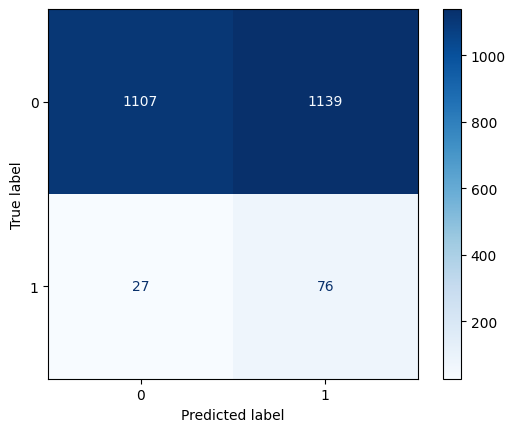

In [ ]:
# Best model
# best_log_reg = LogisticRegression(max_iter = 1000, **grid_search.best_params_, random_state = 42)
best_log_reg = LogisticRegression(max_iter = 1000, solver = "liblinear", C = 100, random_state = 42)

# Fitting model
best_log_reg.fit(X_resampled_ada, y_resampled_ada)

# Testing best model
y_hat_test = best_log_reg.predict(X_test_standardised)

# Calculating metrics
accuracy = best_log_reg.score(X_test_standardised, y_test)
precision = precision_score(y_test, y_hat_test)
recall = recall_score(y_test, y_hat_test)
loss = log_loss(y_test, y_hat_test)
auc = roc_auc_score(y_test, y_hat_test)

# Printing metrics
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test Loss:", loss)
print("Test AUC:", auc)

print(classification_report(y_test, y_hat_test))
print("Matthew's Correlation Coefficient:", matthews_corrcoef(y_test, y_hat_test))
print()

# Confusion matrix
cm = confusion_matrix(y_test, y_hat_test)
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_log_reg.classes_)
display.plot(cmap = "Blues")

From the above, the Logistic Regression model performs worse than the XGBoost model in all metrics except recall. Thus, this model, due to it's inherent simplicity, may not be suitable to classify fraud for this dataset.

Form the confusion matrix, Logistic Regression was able to predict many true negatives and true positives. However, it also wrongly classifed many negatives as positives (False positive). This thereby makes it the least desirable of the three models.

# Saving the model

Using `joblib`, the trained model with best parameters will be saved.

In [8]:
# Best model
best_log_reg = LogisticRegression(max_iter = 1000, solver = "liblinear", C = 100, random_state = 42)

# Fitting model
best_log_reg.fit(X_resampled_ada, y_resampled_ada)

# Saving the model
joblib.dump(best_log_reg, 'logistic.joblib')
print("Model saved!")

Model saved!
